<a href="https://colab.research.google.com/github/subiksha-sivakumar/Sparks/blob/main/CV_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SUBIKSHA SHREE S**
COMPUTER VISION AND INTERNET OF THINGS TASK 1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### `Working on MNIST data set available on PyTorch`

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
train_data


Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw




Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw




Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)#Shuffled to avoid training the model in sequence
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)    

torch.Size([1, 1, 28, 28])


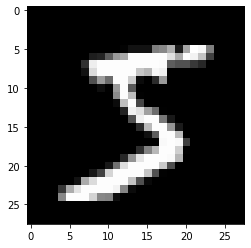

In [ ]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

Labels:  [   2    0    0    2    3    7    2    4    1    6]


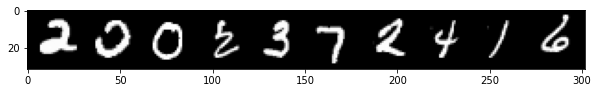

In [ ]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [ ]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [ ]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
# Perform the second convolution/activation
x = F.relu(conv2(x))


In [ ]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()#defining loss criteria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#Adam optimizer is used as it found to give better results

In [ ]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.12849796  accuracy:  73.367%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.05061589  accuracy:  83.475%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.01070914  accuracy:  87.172%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.08332171  accuracy:  89.296%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.02307832  accuracy:  90.640%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.13950506  accuracy:  91.619%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00171925  accuracy:  92.345%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00874098  accuracy:  92.960%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.22330384  accuracy:  93.437%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.05189470  accuracy:  93.832%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00234967  accuracy:  97.633%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00533757  accuracy:  97.550%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.04656784  accuracy:  97.583%
epoch:  1  b

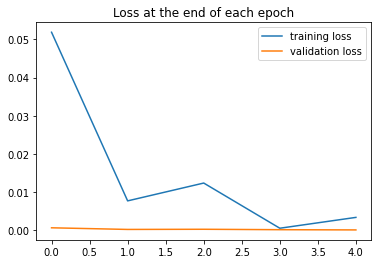

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

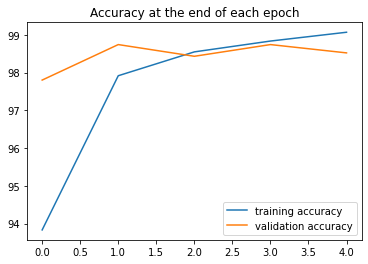

In [ ]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9852/10000 =  98.520%


Index: [ 62 115 149 184 321 340 415 444 445 495 583 659]
Label: [9 4 2 8 2 5 7 2 6 8 2 2]
Guess: [5 9 3 3 7 3 9 3 0 0 7 7]


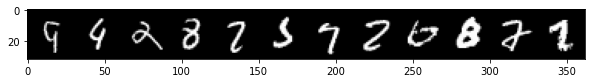

In [ ]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));        